In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from datetime import datetime, timedelta



In [310]:
from models import Process, Langevin, CombinedModel, Singer, ERV
from drivers import GaussianDriver, AlphaStableDriver, NormalGammaDriver, NormalTemperedStableDriver
from example import visualise_langevin, visualise_process, visualise_singer, visualise_erv

In [4]:
def format_plt():
    """
    Formats matplotlib to appear use Latex + Seaborn theme.
    """
    global plt
    plt.rcParams.update(
        {
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],  # or another LaTeX font
            "axes.grid": False,
            "text.color": "black",
        }
    )
    plt.rcParams["figure.figsize"] = [5, 5]
    plt.style.use("seaborn-v0_8-bright")

format_plt()

In [5]:
seed = 100

In [6]:
start_time = datetime.now().replace(microsecond=0)

## START DEBUG

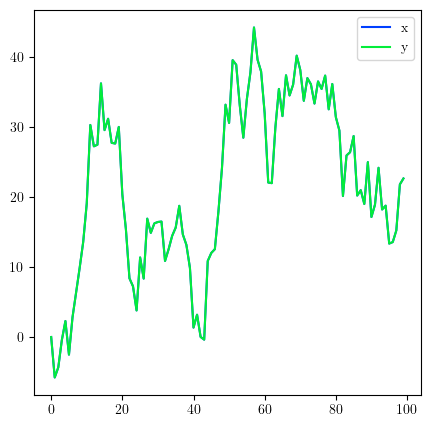

In [38]:
# Try same drivers now, should expect same trajectories

mu_W = 0.
sigma_W = 5.

gaussian_driver = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed)
process_x = Process(gaussian_driver=gaussian_driver)
# gaussian_driver.add_model(process_x) #Bind driver
process_y = Process(gaussian_driver=gaussian_driver)
# gaussian_driver.add_model(process_y)

assert(id(gaussian_driver._master) == id(process_x))
assert(id(gaussian_driver._master) != id(process_y))

initial = np.atleast_2d([0]).T
truth_x = [initial]
truth_y = [initial]

for k in range(1, 100):
    truth_x.append(process_x.function(state=truth_x[k-1], noise=True, time_interval=timedelta(seconds=1)))
    truth_y.append(process_y.function(state=truth_y[k-1], noise=True, time_interval=timedelta(seconds=1)))
    
pos_x = [s[0, :] for s in truth_x]
pos_y = [s[0, :] for s in truth_y]
plt.plot(pos_x, label='x')
plt.plot(pos_y, label='y')
plt.legend()

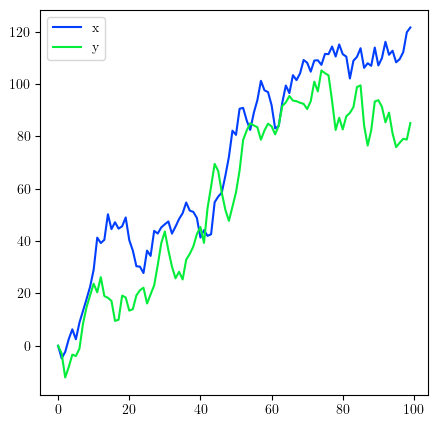

In [39]:
# Try different drivers now, should expect diff trajectories

mu_W = 1.
sigma_W = 5.

gaussian_driver_x = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed)
process_x = Process(gaussian_driver=gaussian_driver_x)
# gaussian_driver_x.add_model(process_x) #Bind driver

gaussian_driver_y = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed + 1) # seed differently than x
process_y = Process(gaussian_driver=gaussian_driver_y)
# gaussian_driver_y.add_model(process_y)

initial = np.atleast_2d([0]).T
truth_x = [initial]
truth_y = [initial]

for k in range(1, 100):
    truth_x.append(process_x.function(state=truth_x[k-1], noise=True, time_interval=timedelta(seconds=1)))
    truth_y.append(process_y.function(state=truth_y[k-1], noise=True, time_interval=timedelta(seconds=1)))


pos_x = [s[0, :] for s in truth_x]
pos_y = [s[0, :] for s in truth_y]
plt.plot(pos_x, label='x')
plt.plot(pos_y, label='y')
plt.legend()

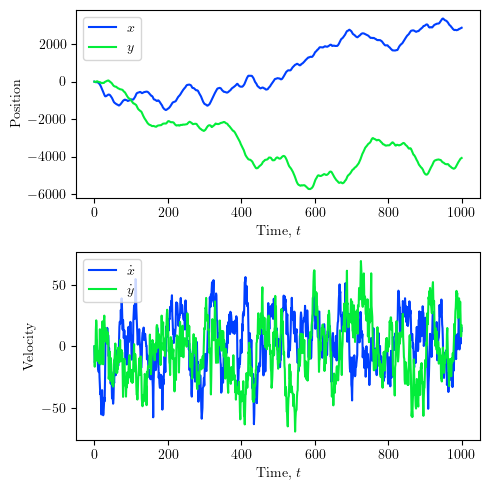

In [107]:
# Test gaussian langevin

mu_W = 0.
sigma_W = 10.
theta = -0.1


gaussian_driver_x = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=5)
langevin_x = Langevin(theta=theta, gaussian_driver=gaussian_driver_x)
# gaussian_driver_x.add_model(langevin_x) #Bind driver

gaussian_driver_y = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed + 1) # seed differently than x
langevin_y = Langevin(theta=theta, gaussian_driver=gaussian_driver_y)
# gaussian_driver_y.add_model(langevin_y)

transition_model = CombinedModel(langevin_x, langevin_y)

initial = np.zeros((2, 2))
truth = [initial]
times = [0]

for k in range(1, 1000):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_langevin(times, truth[..., 0:1], truth[..., 1:2])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')

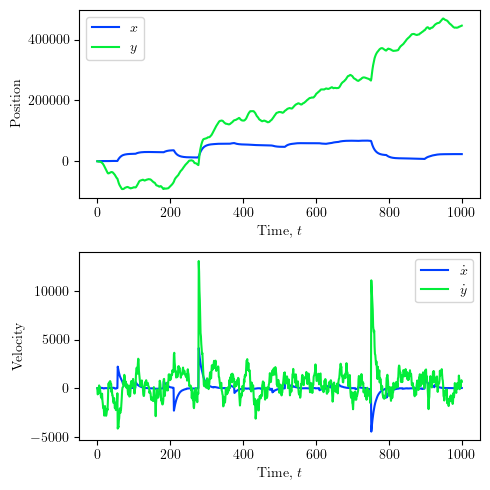

In [57]:
# Test non-Gaussian langevin

mu_W = 0.
sigma_W = 1.
mu_B = 1.
sigma_B = 500.
theta = -0.1
c=10
alpha=0.8

as_driver_x = AlphaStableDriver(c=c, alpha=alpha, mu_W=mu_W, sigma_W=sigma_W, seed=seed+3)
langevin_x = Langevin(theta=theta, non_gaussian_driver=as_driver_x)
# as_driver_x.add_model(langevin_x) #Bind driver

# Add a gaussian noise to the 2nd dimension
gaussian_driver_y = GaussianDriver(mu_W=mu_B, sigma_W=sigma_B, seed=5)
langevin_y = Langevin(theta=theta, non_gaussian_driver=as_driver_x, gaussian_driver=gaussian_driver_y)
# gaussian_driver_y.add_model(langevin_y) #Bind driver
# as_driver_x.add_model(langevin_y)

transition_model = CombinedModel(langevin_x, langevin_y)

initial = np.zeros((2, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 1000):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_langevin(times, truth[..., 0:1], truth[..., 1:2])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')

## Normal Gamma

Truncation: 3.05902414078084e-07


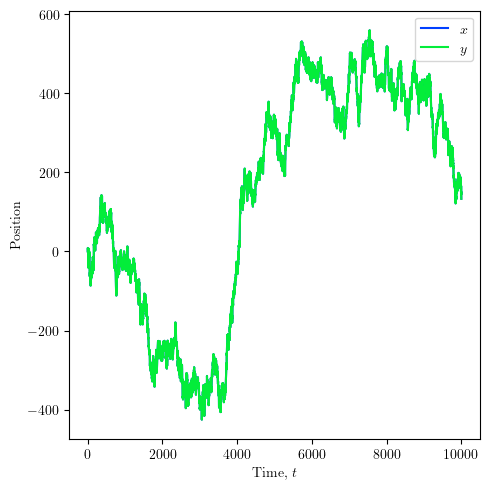

In [317]:
# Test normal gamma process

mu_W = 0.
sigma_W = 2.
gamma = np.sqrt(2.)
beta = (gamma ** 2) / 2.
nu = 2
c = 30


ngamma_driver_x = NormalGammaDriver(nu=nu, beta=beta, mu_W=mu_W, sigma_W=sigma_W, c=c, seed=seed+2, noise_case=2)
process_x = Process(non_gaussian_driver=ngamma_driver_x)

transition_model = CombinedModel(process_x)

initial = np.zeros((1, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 10000):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_process(times, truth[..., 0:1], truth[..., 0:1])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')


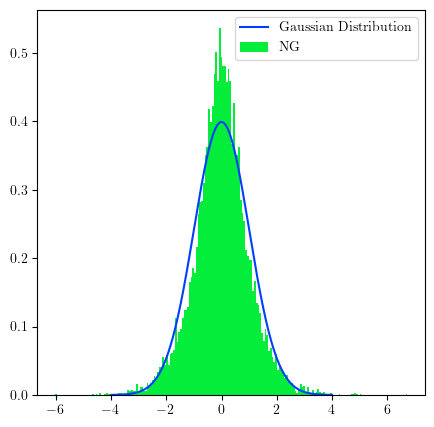

In [318]:
from scipy.stats import norm
# Parameters for the Gaussian distribution
mean = 0
std_dev = 1

# Generate data points
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Calculate the probability density function (PDF) for each data point
pdf_values = norm.pdf(x, mean, std_dev)

# Plot the Gaussian distribution
plt.plot(x, pdf_values, label='Gaussian Distribution')
# Double check if noise 
noise = np.array(ngamma_driver_x.debug_jumps)
noise = (noise - np.mean(noise)) / np.std(noise) 
plt.hist(noise, density=True, bins=200, label='NG')
plt.legend()



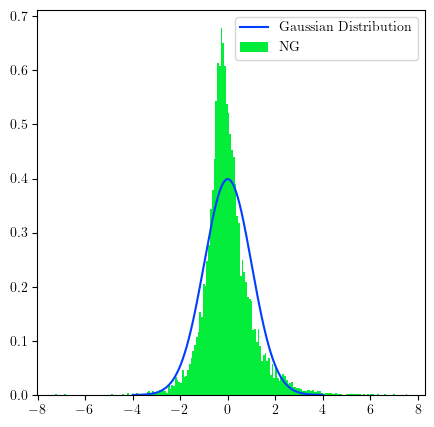

In [280]:
from scipy.stats import norm
# Parameters for the Gaussian distribution
mean = 0
std_dev = 1

# Generate data points
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Calculate the probability density function (PDF) for each data point
pdf_values = norm.pdf(x, mean, std_dev)

# Plot the Gaussian distribution
plt.plot(x, pdf_values, label='Gaussian Distribution')
# Double check if noise 
noise = np.diff(truth[..., 0].flatten())
noise = (noise - np.mean(noise)) / np.std(noise) 
plt.hist(noise, density=True, bins=200, label='NG')
plt.legend()


## Normal Tempered Stable

Truncation: 0.0004


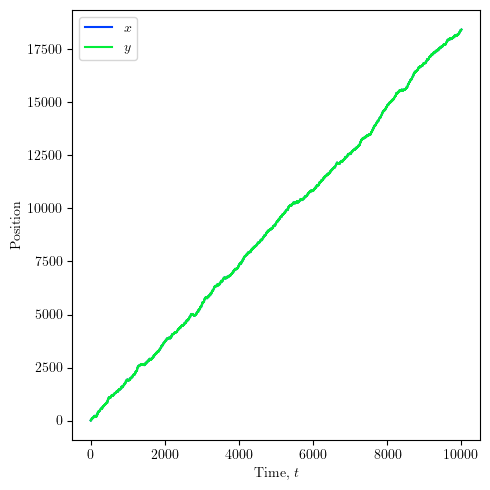

In [284]:

mu_W = 1.
sigma_W = 2.
nu = 1
kappa = 0.5
gamma = 1.35
beta = (gamma ** (1 / kappa)) / 2.
c = 100


nts_driver_x = NormalTemperedStableDriver(kappa=kappa, nu=nu, beta=beta, mu_W=mu_W, sigma_W=sigma_W, c=c, seed=seed)
process_x = Process(non_gaussian_driver=nts_driver_x)

transition_model = CombinedModel(process_x)

initial = np.zeros((1, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 10000):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_process(times, truth[..., 0:1], truth[..., 0:1])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')


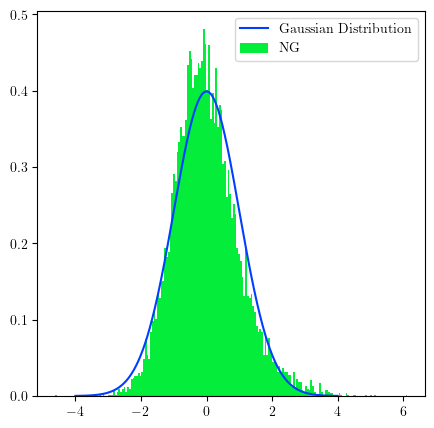

In [285]:
from scipy.stats import norm
# Parameters for the Gaussian distribution
mean = 0
std_dev = 1

# Generate data points
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Calculate the probability density function (PDF) for each data point
pdf_values = norm.pdf(x, mean, std_dev)

# Plot the Gaussian distribution
plt.plot(x, pdf_values, label='Gaussian Distribution')
# Double check if noise 
noise = np.array(nts_driver_x.debug_jumps)
noise = (noise - np.mean(noise)) / np.std(noise) 
plt.hist(noise, density=True, bins=200, label='NG')
plt.legend()



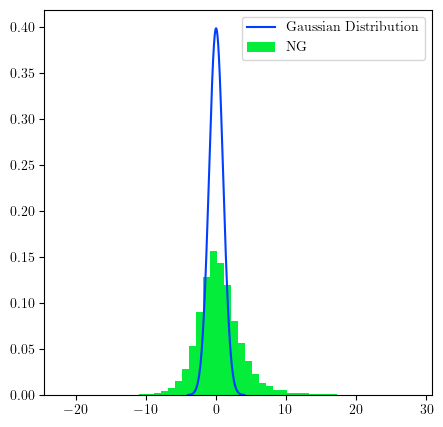

In [286]:
from scipy.stats import norm
# Parameters for the Gaussian distribution
mean = 0
std_dev = 1

# Generate data points
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Calculate the probability density function (PDF) for each data point
pdf_values = norm.pdf(x, mean, std_dev)

# Plot the Gaussian distribution
plt.plot(x, pdf_values, label='Gaussian Distribution')
# Double check if noise 
noise = (np.diff(truth[..., 0].flatten()) - mu_W) / sigma_W 
plt.hist(noise, density=True, bins=50, label='NTS')
plt.legend()


## Singer 

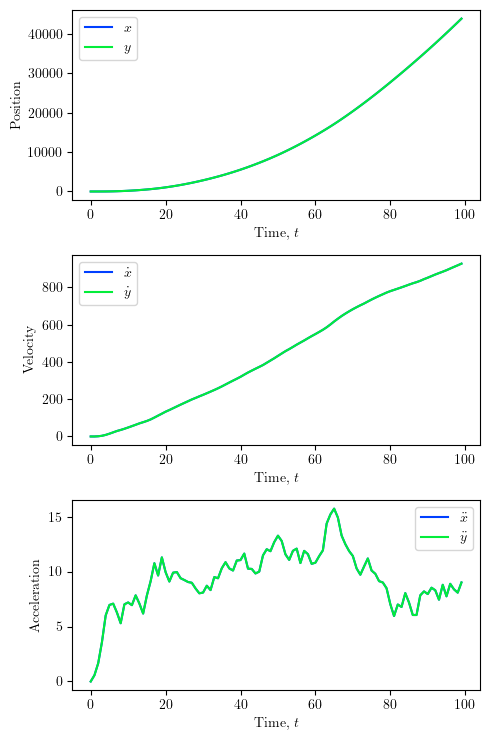

In [314]:
# Test Gaussian Singer

mu_W = 0.
sigma_W = 1.
theta = -0.1


g_driver_x = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed)
singer_x = Singer(theta=theta, gaussian_driver=g_driver_x)

singer_y = Singer(theta=theta, gaussian_driver=g_driver_x)
transition_model = CombinedModel(singer_x, singer_y)

initial = np.zeros((3, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 100):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_singer(times, truth[..., 0:1], truth[..., 1:2])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')

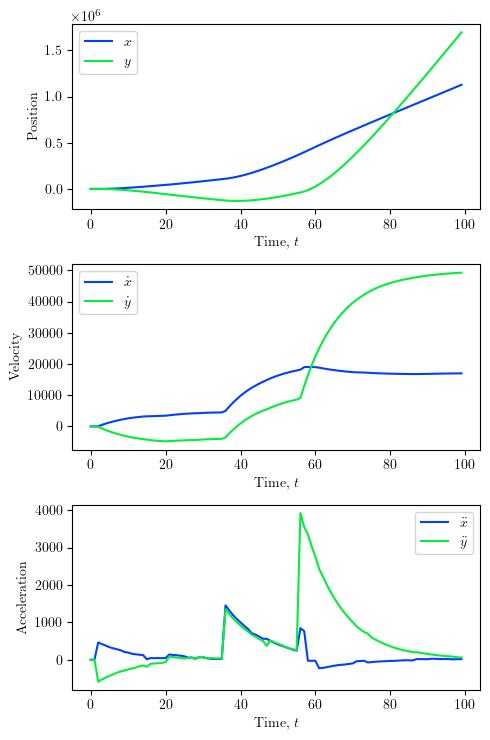

In [316]:
# Test non-Gaussian Singer

mu_W = 0.
sigma_W = 1.
theta = -0.1
c=10
alpha=0.8

as_driver_x = AlphaStableDriver(c=c, alpha=alpha, mu_W=mu_W, sigma_W=sigma_W, seed=seed)
singer_x = Singer(theta=theta, non_gaussian_driver=as_driver_x)

# as_driver_y = AlphaStableDriver(c=c, alpha=alpha, mu_W=mu_W, sigma_W=sigma_W, seed=seed+1)
singer_y = Singer(theta=theta, non_gaussian_driver=as_driver_x)
transition_model = CombinedModel(singer_x, singer_y)

initial = np.zeros((3, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 100):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_singer(times, truth[..., 0:1], truth[..., 1:2])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')

## ERV

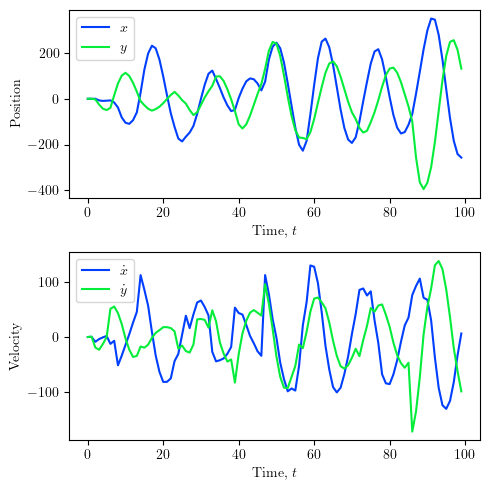

In [312]:
# Test non-Gaussian ERV

mu_W = 0.
sigma_W = 1.
rho = 0.1
eta = 0.2
p = 0.2
c=10
alpha=0.8

as_driver_x = AlphaStableDriver(c=c, alpha=alpha, mu_W=mu_W, sigma_W=sigma_W, seed=seed)
erv_x = ERV(rho=rho, eta=eta, p=p, non_gaussian_driver=as_driver_x)

erv_y = ERV(rho=rho, eta=eta, p=p, non_gaussian_driver=as_driver_x)
transition_model = CombinedModel(erv_x, erv_y)

initial = np.zeros((2, transition_model.n_models()))
truth = [initial]
times = [0]

for k in range(1, 100):
    times.append(k)
    truth.append(transition_model.function(state=truth[k-1], noise=True, time_interval=timedelta(seconds=1)))

truth = np.array(truth)
fig = visualise_erv(times, truth[..., 0:1], truth[..., 1:2])
# fig.suptitle(r"Langevin model example")
# plt.savefig("milestone-report/assets/langevin1.pdf", bbox_inches='tight')

## END DEBUG

In [27]:
# Gaussian

mu_W = 0.
sigma_W = 5.

gaussian_driver = GaussianDriver(mu_W=mu_W, sigma_W=sigma_W, seed=seed)
process = Process(dims=1, gaussian_driver=gaussian_driver)
#Bind driver
# gaussian_driver.add_model(process)


# transition_model = CombinedLinearTransitionModel([gaussian_driver])


In [ ]:
timesteps = [start_time]
truth = GroundTruthPath([GroundTruthState([0, 0, 0, 0], timestamp=timesteps[0])])

num_steps = 100
for k in range(1, num_steps + 1):
    timesteps.append(start_time+timedelta(seconds=k))  # add next timestep to list of timesteps
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=timesteps[k]))